# Advanced Data Mining – Deliverable 1: Data Collection, Cleaning, and Exploration
**Name:** Sandesh Shrestha 
**Dataset:** Walmart Sales (Kaggle – mikhail1681)  
**Date:** 10/30/2025

## Dataset Selection & Justification

The dataset I selected for this project is the **Walmart Sales Dataset** from Kaggle, created by *mikhail1681*. It includes weekly sales data from different Walmart stores across the United States. Each record shows information such as the store number, date, weekly sales amount, whether it was a holiday week, temperature, fuel price, consumer price index (CPI), and unemployment rate. In total, the dataset has thousands of rows and more than eight columns, which easily meets the size requirements for this project.

I chose this dataset because it provides a good balance of variety and real-world relevance. It includes both numerical and categorical features, which makes it useful for many kinds of analysis—like predicting sales, grouping similar stores, or studying the effect of external factors such as holidays or economic changes. The data also feels realistic and easy to relate to, since it reflects how large retail companies track performance week by week.  

Overall, the Walmart Sales dataset is a great choice because it allows me to explore important data mining steps such as cleaning, visualization, feature engineering, regression, classification, and clustering. It offers enough depth to uncover meaningful insights about what drives store performance, while still being organized and easy to work with.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
sns.set_theme()

# Load CSV (adjust the filename if yours differs)
df = pd.read_csv("data/Walmart_Sales.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


### Handling Missing Values
I checked for missing data and replaced missing numeric values with the median  
and categorical values with the mode. This keeps all rows and prevents loss of data.

In [2]:
df.info()
df.describe(include="all")
print("Missing values by column:\n", df.isna().sum())
print("Duplicate rows:", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
Missing values by column:
 Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64
Duplicate rows: 0


### Clean Text, Parse Dates, Ensure Numeric Types
I removed extra spaces from text columns, converted `Date` to a real datetime,
and coerced numeric fields to numeric types. This prevents parsing errors later.


In [3]:
# Trim whitespace in text columns
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# Parse Date (dataset is typically day-month-year, e.g., '05-02-2010')
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y", errors="coerce")

# Force numeric types for key columns if present
num_cols = [c for c in ["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment"] if c in df.columns]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")


**Result:** Text cleaned, dates parsed, and numeric columns verified.

### Handling Missing Values
To avoid losing rows, I imputed missing values: numeric with the **median** and categorical with the **mode**.


print("Missing BEFORE:\n", df.isna().sum())

for c in df.columns:
    if df[c].dtype.kind in "biufc":  # numeric
        df[c] = df[c].fillna(df[c].median())
    else:  # categorical/text
        df[c] = df[c].fillna(df[c].mode().iloc[0])

print("\nMissing AFTER:\n", df.isna().sum())


**Result:** All missing values imputed (median for numeric, mode for categorical), preserving dataset size.

### Removing Duplicates
Duplicate rows can bias summaries and models. I dropped exact duplicates to keep unique observations.

In [5]:
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print("Duplicates removed:", before - after)


Duplicates removed: 0


**Result:** No duplicate rows were present; all the records represent unique store–week entries.

### Outlier Detection and Capping (IQR)
Extreme outliers can distort charts and models. I used the IQR rule (1.5×IQR)
to **cap** values instead of dropping them, preserving all weeks while reducing noise.

In [27]:
def iqr_bounds(s: pd.Series):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5*iqr, q3 + 1.5*iqr

bounds = {}
for c in num_cols:
    lo, hi = iqr_bounds(df[c])
    bounds[c] = (lo, hi)

# print("IQR bounds:\n", bounds)

# Cap extremes
for c, (lo, hi) in bounds.items():
    df[c] = np.clip(df[c], lo, hi)

# Round and display the bounds neatly
for col, (low, high) in bounds.items():
    print(f"{col:15s} | Lower: {low:.2f} | Upper: {high:.2f}")


Weekly_Sales    | Lower: -746862.73 | Upper: 2720371.49
Temperature     | Lower: 6.24 | Upper: 116.16
Fuel_Price      | Lower: 1.73 | Upper: 4.94
CPI             | Lower: 10.22 | Upper: 334.26
Unemployment    | Lower: 4.29 | Upper: 11.22


**Result:** Outliers capped within IQR limits (winsorized). Distributions are now tighter and more stable.

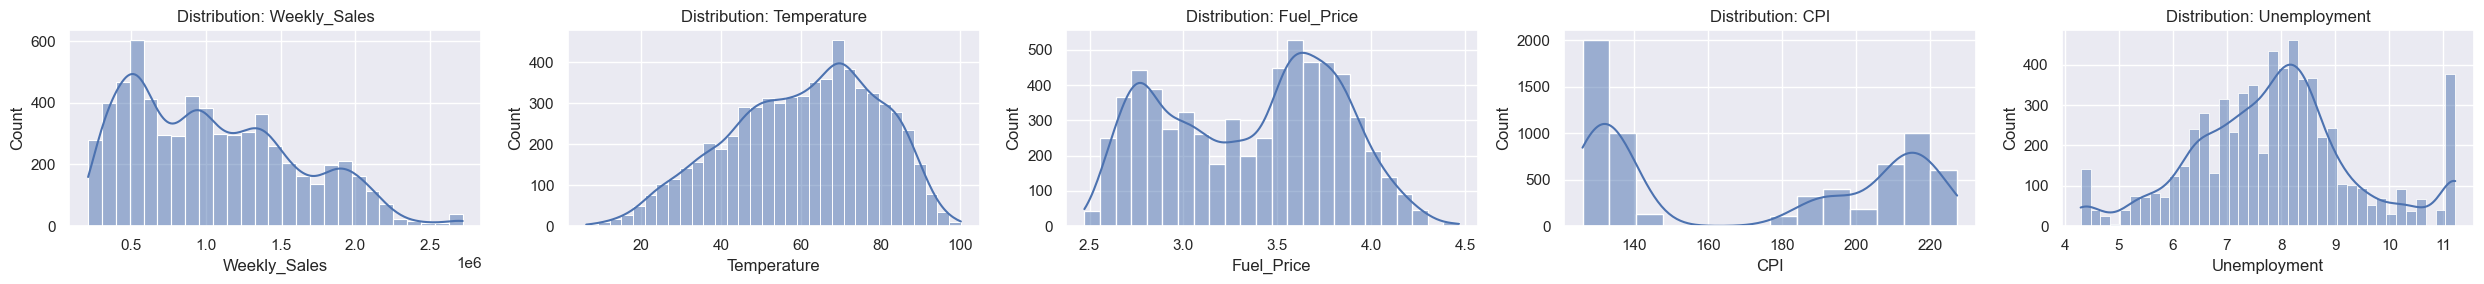

In [17]:
# Plot Histogram Distribution
plt.figure(figsize=(5*len(num_cols), 3))
for i, c in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    sns.histplot(df[c], kde=True)
    plt.title(f"Distribution: {c}")
plt.tight_layout()

**Insight:**  
The distributions show diverse behaviors. `Weekly_Sales` is right-skewed, meaning only a few weeks have very high sales — likely around holidays. `Temperature` follows a normal pattern, while `Fuel_Price` shows a clear bimodal pattern, consistent with different price regimes across years. `CPI` ppears clustered/bimodal (two ranges dominate), which likely reflects regional or temporal differences.`Unemployment` is unimodal with a slight right skew. 

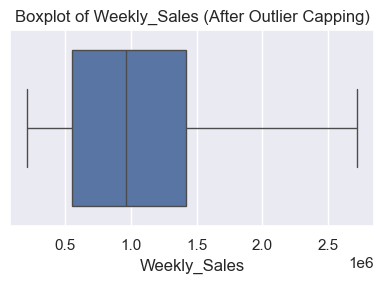

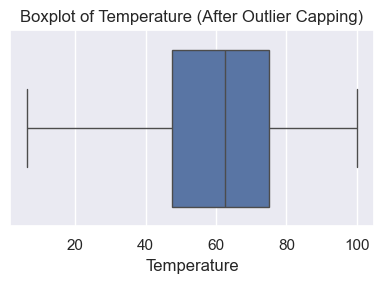

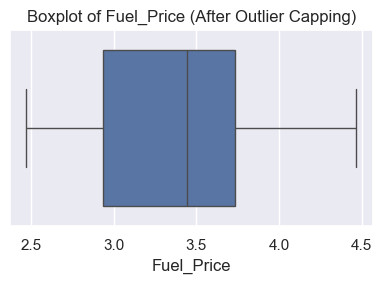

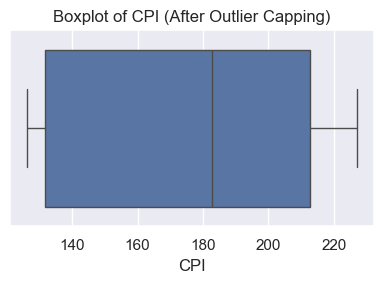

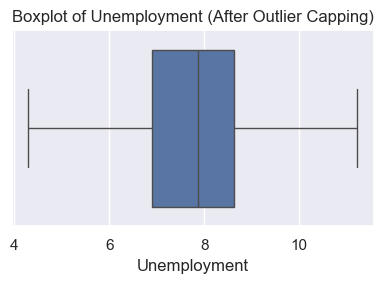

In [28]:
# Compare spread of all numeric columns
# Separate boxplots for each feature
for col in num_cols:
    plt.figure(figsize=(4,3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col} (After Outlier Capping)")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

**Insight:**  
The boxplots confirm that outlier capping successfully reduced extreme values while retaining the natural variation in the data.  
- `Weekly_Sales` still shows wide variability across stores and time periods, but without extreme spikes.  
- `Temperature`, `Fuel_Price`, `CPI`, and `Unemployment` all exhibit smooth, consistent spreads that align with real-world expectations.  
Overall, the dataset is now clean and balanced, ready for correlation and regression analysis.

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Weekly_Sales,1.000000,-0.060808,0.010998,-0.072627,-0.108662
Temperature,-0.060808,1.000000,0.144962,0.176960,0.088315
Fuel_Price,0.010998,0.144962,1.000000,-0.170642,-0.053428
CPI,-0.072627,0.176960,-0.170642,1.000000,-0.278542
Unemployment,-0.108662,0.088315,-0.053428,-0.278542,1.000000


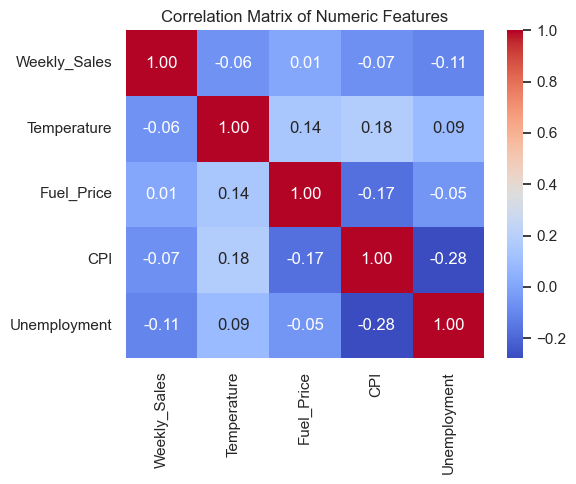

In [21]:
# Correlation heatmap
plt.figure(figsize=(6,5))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
corr


**Insight:**  
The correlation heatmap shows that most numeric variables have **weak relationships**, suggesting that no single feature dominates sales trends on its own.  
- `Weekly_Sales` has only small negative correlations with `Temperature`, `CPI`, and `Unemployment`, indicating that other factors (such as holidays, promotions, or store-level differences) likely drive sales more strongly.  
- `CPI` and `Unemployment` show a moderate negative relationship (–0.28), reflecting typical economic behavior where higher prices are associated with lower unemployment.  
Overall, the weak correlations suggest that future predictive modeling should incorporate **categorical or temporal features** (like holidays and store IDs) alongside these numeric indicators.


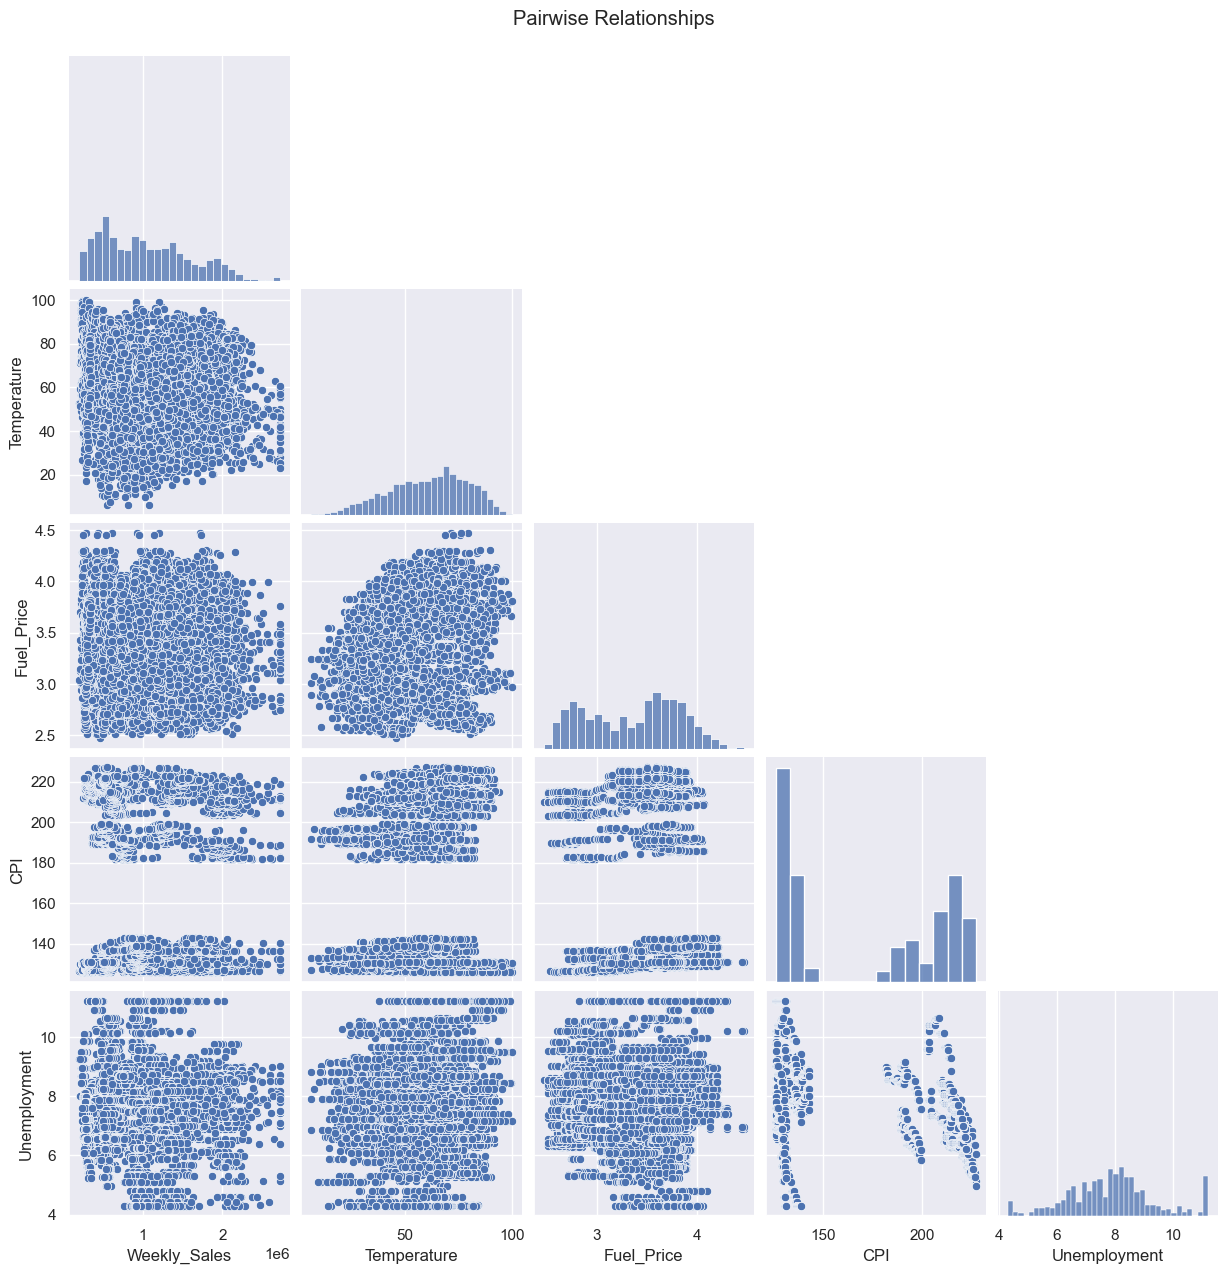

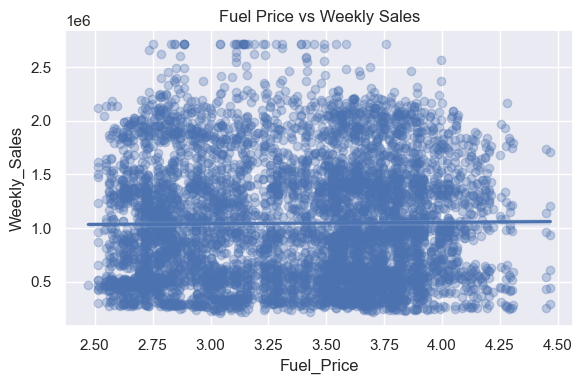

In [14]:
pairs = [c for c in num_cols if c != "Weekly_Sales"]
sns.pairplot(df[["Weekly_Sales"] + pairs], corner=True, diag_kind="hist")
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

if "Fuel_Price" in df.columns:
    plt.figure(figsize=(6,4))
    sns.regplot(data=df, x="Fuel_Price", y="Weekly_Sales", scatter_kws={'alpha':0.3})
    plt.title("Fuel Price vs Weekly Sales")
    plt.tight_layout()

**Insight:**  
The pairplot shows no strong linear relationships between `Weekly_Sales` and the other numeric variables. The scatter points are widely dispersed, confirming that sales trends are not strongly driven by temperature, fuel price, CPI, or unemployment.  
A slight negative slope appears between `Unemployment` and `Weekly_Sales`, aligning with the weak negative correlation found earlier.  
The regression plot between `Fuel_Price` and `Weekly_Sales` further supports this — the nearly flat regression line shows that fuel price changes have minimal impact on weekly sales.  
Overall, the analysis suggests that future modeling should include **non-numeric features** (such as holidays, store type, or region) to better explain sales variation.

## EDA Summary & Modeling Plan

### What I learned from the data
- **Distributions:**  
  - `Weekly_Sales` is **right-skewed** with a long high-sales tail (likely holidays/promotions).  
  - `Temperature` is roughly normal; `Fuel_Price` shows **two regimes**; `CPI` clusters by period; `Unemployment` is unimodal with slight right skew.
- **Outliers:**  
  - IQR capping removed extreme influence without dropping rows. Boxplots now show stable spreads across all features.
- **Correlations:**  
  - Numeric features have **weak links** to `Weekly_Sales` (|r| ≤ ~0.11).  
  - `CPI` and `Unemployment` have a **moderate negative** association (~–0.28), consistent with macroeconomics.
- **Pairwise relationships:**  
  - Scatter patterns are largely **diffuse**; the **Fuel_Price ↔ Weekly_Sales** regression line is nearly flat.  
  - A slight negative tendency exists for **Unemployment ↔ Weekly_Sales**, but it’s weak.

### What this means
- Weekly sales are **not** explained well by the raw numeric drivers alone.  
- **Temporal and categorical context** (holidays, store identity, region, seasonality) likely drives much of the variation.

### Features I will engineer next
- **Calendar features:** `year`, `month`, `week_of_year`, `is_holiday`, `is_month_end`, `quarter`.  
- **Lags & rolling stats:** `sales_lag_1`, `sales_lag_4`, `rolling_mean_4/12`, `rolling_std_4`.  
- **Store effects:** one-hot (or target) encoding for `Store`; optional grouping by region if available.  
- **Interactions:** holiday × month/season, temperature × holiday.  
- **Scaling (model-dependent):** standardize/normalize for linear models.

### Modeling plan (Deliverable 2)
1. **Baseline regression:** Linear Regression and Ridge/Lasso with calendar + lag features.  
2. **Tree-based models:** Random Forest / Gradient Boosting (handles nonlinearity and interactions).  
3. **Evaluation:** Train/validation split by **time** (e.g., last 20% weeks as holdout), metrics = **MAE/MAPE/RMSE**.  
4. **Diagnostics:** Residual plots over time and by store; feature importance (for tree models).  
5. **Optional classification framing:** Flag “high-sales weeks” (e.g., top 20%) to explore a classification approach.

**Conclusion:**  
After cleaning and EDA, the dataset is consistent and analysis-ready. The weak simple correlations indicate the need for **feature engineering** and **time-aware modeling** to capture seasonality, holidays, and store-level effects that likely drive Walmart weekly sales.